In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

# 1. Maximum Time Under Water

Load the funds data

In [2]:
funds = pk.load(open("funds.p", "rb"))

## Question 1:

**Output**: <br>
The function ```firsthit(df,k)``` returns the first index for which the value in the DataFrame df is bigger than k. <br>

**Algorithm**: <br>
A counter ```i``` is initialised at 0 and will be used to go through the dataframe ```df```. With a loop, we look at each instance and compare it to ```k```. If the value is smaller than ```k```, we increment the counter by 1. The loop ends at the first value that is above ```k``` or ends at the end of the dataframe. <br>
If the counter is not equal to the last index of the dataframe, we return it, as it contains the position of the first element above ```k```.
If the counter is equal to the last index of the dataframe, we only return it if that last value is indeed above ```k```. Otherwise, we return the sentence ```'not in the dataframe'```.



In [3]:
def firsthit(df : pd.DataFrame, k : float):
    # Counter
    i = 0 
    
    # Loop
    while df.iloc[i] < k and i < len(df)-1: 
        i += 1
    
    # Output
    if i < len(df)-1: 
        return int(i)
    else:
        if df.iloc[i] >= k: 
            return int(i)
        else:
            return 'not in the df' 

## Question 2

**Output**: <br>
The function ```underwater(df)``` returns the start of the longest period under water and its end date, as well as its duration. <br>

**Algorithm**: <br>
We initialise two empty arrays ```highwatermark``` and ```recov``` that will respectively contain the start dates and end dates of the period underwater. We initialise the variable ```HWM```that will be used to store the High Water Mark through time. <br>
We then loop through the dataframe. At each date, we check if the value of the fund started to decrease. If it did so, we check if its level was above the last highwater mark (i.e. it was a maximum for the fund value). If both conditions were fulfilled, we stored the beginning of the period under water and the level of the High Water Mark. We then use the previously defined function to find the index of the first time the fund reovers to the high water mark value and store that date as the end of the period under water.<br>
After the loop, we compare the two lists containing the dates. If the list containng the recovery dates is smaller, it means that the fund did not recover at the end of the period and we just add the last date as the end of the period under water.
We then compute the period of all the time under water and return the dates for the longest period. If there was no time under water, we return 'There was no time under water'

In [4]:
def underwater(df: pd.DataFrame):
    
    # Initialise
    highwatermark =[]
    recov = []
    HWM = 0
    
    # For loop over the dates
    for i in range(1,len(df)):
        #if df.iloc[i-1] > df.iloc[i] and df.iloc[i-1] == max(df.iloc[0:i-1]):
        if df.iloc[i-1] > df.iloc[i] and df.iloc[i-1] > HWM:
            highwatermark.append(df.index[i-1])
            HWM = df.iloc[i-1]
            r = firsthit(df.iloc[i:],HWM)
            
            if r != 'not in the df':
                recov.append(df.index[r+i])
                
    if len(recov) < len(highwatermark):
        recov.append(df.index[-1])
    length = [(r_i - h_i).days for r_i, h_i in zip(recov, highwatermark)]
    
    if length:
        M = max(length)
        Idx = length.index(M)
        return highwatermark[Idx], recov[Idx], M
    else:
        return None        

## Question 3

We apply the function previously defined in question 2 to all funds and display the results in a DataFrame. We then return the name of the fund that had the longest period under water.

In [5]:
def maxTimeUnderWater(val: pd.DataFrame):
    #Applies the function to all the columns 
    return list(map(lambda i: underwater(val[i]), val.columns))

L = maxTimeUnderWater(funds)
idx = funds.columns
Col = ['Start date', 'End date', 'Length']
UnderWater = pd.DataFrame(L, index = idx, columns = Col)
UnderWater

,Start date,End date,Length
BlackRock Multi-Asset Income Portfolio,2022-01-04,2023-03-31,451.0
iShares iBoxx $ High Yield Corporate Bond ETF,2021-12-27,2023-03-31,459.0
BlackRock Equity Dividend Fund,2022-04-20,2023-03-31,345.0
iShares 20+ Year Treasury Bond ETF,2020-08-04,2023-03-31,969.0
Vanguard Equity-Income Fund Investor Shares,2018-01-26,2019-04-05,434.0
Cash,NaT,NaT,NaN


In [6]:
print(UnderWater['Length'].idxmax(),' had the longest period under water.')

iShares 20+ Year Treasury Bond ETF  had the longest period under water.


# 2. Factor-Based Covariance Matrix Estimation

## Question 1

We load the weekly values of the factors and the daily values of the 10x10 portfolios. We convert the index to a DateTime format and use the indices to only keep the relevant period.

In [7]:
# Loading the data
factors = pd.read_csv('/Users/ilyas/Library/CloudStorage/OneDrive-Personnel/EDHEC/M2/Empirical Methods in Finance/Assignment/F-F_Research_Data_Factors_weekly.csv', delimiter=",", skiprows=4,
                 index_col=0, nrows = 5065)
portfolios = pd.read_csv('/Users/ilyas/Library/CloudStorage/OneDrive-Personnel/EDHEC/M2/Empirical Methods in Finance/Assignment/100_Portfolios_10x10_Daily.csv', delimiter=",", skiprows=18,
                 index_col=0, nrows = 25543)

# Changing the index format
factors.index = pd.to_datetime(factors.index, format='%Y%m%d')
portfolios.index = pd.to_datetime(portfolios.index, format='%Y%m%d')
portfolios.index.name = 'Date'

# Keeping the data for the relevant dates
portfolios = portfolios.drop(portfolios.index[portfolios.index < np.datetime64('1970-01-02')])
portfolios = portfolios.drop(portfolios.index[portfolios.index > np.datetime64('2023-07-28')])

factors = factors.drop(factors.index[factors.index < np.datetime64('1970-01-02')])
factors = factors.drop(factors.index[factors.index > np.datetime64('2023-07-28')])

## Question 2

Deleting the columns that contain the value -99.99, which means missing data.

In [8]:
portfolios = portfolios.loc[:, ~(portfolios == -99.99).any()]

## Questions 3

**Output**: <br>
We get the compounded daily reutrns, starting with 1 dollar on the 2nd of January 1970.<br>

**Algorithm**: <br>
We get the returns in the decimal form (1+r) and set the first value to 1. We then compound them using the cumprod function from the numpy package.

In [9]:
dailyport = portfolios
dailyport = (dailyport/100)+1
dailyport.iloc[0] = 1                                                
dailyport = np.cumprod(dailyport)
dailyport

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
Date,,,,,,,,,,,,,,,,,,,,,
1970-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1970-01-05,1.021700,1.021000,1.032400,1.019200,1.024200,1.014900,1.026300,1.025400,1.025500,1.020700,...,1.011200,1.014200,1.016000,1.003700,0.999700,0.998500,1.010600,0.998200,1.010300,1.008100
1970-01-06,1.012198,1.011198,1.028064,1.011250,1.021332,1.016625,1.024966,1.022529,1.020783,1.021312,...,1.001189,1.003044,1.007364,0.999786,0.993802,0.988515,1.001606,0.991812,0.995449,1.000237
1970-01-07,1.024749,1.016558,1.042148,1.018329,1.028175,1.018862,1.037265,1.026005,1.024253,1.028870,...,1.001289,0.999834,1.004443,1.000885,0.992013,0.989207,0.993292,0.988439,0.991367,0.995436
1970-01-08,1.034382,1.025808,1.042461,1.028614,1.030334,1.023345,1.044837,1.028057,1.025585,1.035558,...,0.999787,1.000534,1.002735,1.004689,0.993104,0.989405,0.986637,0.987056,0.988591,0.995535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-24,0.232477,16.356001,71.719161,90.088474,202.921336,326.973802,780.124256,764.855831,2395.537972,2082.103100,...,147.604398,710.903553,101.665133,162.806407,398.316148,274.111184,316.111204,150.592714,441.321435,32.105489
2023-07-25,0.229223,16.086127,71.453800,89.809199,200.263067,325.142749,767.876305,766.844456,2393.621542,2053.161867,...,147.486315,703.367976,101.024642,163.848368,399.072948,275.235039,316.522149,151.842633,438.188053,31.871119
2023-07-26,0.231584,16.187469,72.804276,90.581558,201.124198,327.743891,777.090821,776.430012,2434.073746,2087.039038,...,148.002517,711.386371,102.883496,162.521197,398.234895,283.712279,316.617105,151.888186,436.347663,32.055972


## Questions 4

**Output**: <br>
The function ```dailytoweekly(df)``` returns a dataframe containing weekly returns computed from the daily returns in ```df``` and aligns the returns to every Friday. <br>

**Algorithm**: <br>
We initialise the list that will contain the weekly returns, the indices of the dates, the value of the product of the returns (which starts at 1).
We loop through the whole dataframe and check the dates: we save the date if the date is a Friday or if the date is a Monday and the previous day was not a Friday, to account for the weeks for which Friday is a holiday. We then keep the date of the last trading day preceding Monday. For each saved date, we save the the compounded returns at the end of the week divided by the compounded returns of the beginning the week, minus one. 


In [10]:
def dailytoweekly(df : pd.DataFrame):
    
    #Initialie
    newdf = []
    idx = []
    N = len(df)

    # For loop over the dates
    for i in range(N):
        # If there was no Friday
        if df.index[i].weekday() == 0 and df.index[i-1].weekday() !=4 :
            newdf.append((df.iloc[i-1]/df.iloc[i-5])-1)
            idx.append(df.index[i-1])

        # If the date is a Friday
        if df.index[i].weekday() == 4:
            newdf.append((df.iloc[i]/df.iloc[i-5])-1)
            idx.append(df.index[i])


        
    return pd.DataFrame(newdf, index =idx)    

In [11]:
portfolios = dailytoweekly(dailyport)*100
portfolios

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,ME1 BM5,ME1 BM6,ME1 BM7,ME1 BM8,ME1 BM9,SMALL HiBM,...,ME9 BM8,ME9 BM9,ME9 BM10,BIG LoBM,ME10 BM2,ME10 BM3,ME10 BM4,ME10 BM5,ME10 BM6,ME10 BM7
1970-01-02,330.149297,-93.886036,-98.605672,-98.889980,-99.507198,-99.694165,-99.871815,-99.869256,-99.958256,-99.951972,...,-99.322513,-99.859334,-99.016379,-99.385774,-99.748943,-99.635185,-99.683656,-99.335957,-99.773408,-96.885268
1970-01-09,3.179614,2.765488,3.568504,2.521969,2.930400,2.078654,3.783703,2.980519,2.414907,3.566134,...,-0.241223,-0.296793,-0.137612,0.529151,-0.729310,-1.613586,-1.859190,-1.748491,-3.108155,-0.506209
1970-01-16,-1.525796,-2.938429,-2.947955,-3.374231,-1.755420,-1.633946,-4.261252,-2.022596,-1.483458,-1.046983,...,-2.672880,-3.044015,-2.224355,-0.259690,-1.602512,-0.333530,-1.389306,-2.694072,-3.287238,-2.172447
1970-01-23,-1.264986,-1.029950,-1.408406,-0.258106,-2.677741,-1.203455,-1.445381,-0.556148,-1.265776,-0.601744,...,-0.501065,0.600992,0.055067,-3.710182,-0.958560,-2.184513,-2.458339,-0.834314,-1.873927,-2.615748
1970-01-30,-4.688495,-6.014008,-5.779961,-3.860775,-4.975592,-5.140416,-4.643336,-4.614304,-3.661865,-2.573562,...,-4.561210,-6.116675,-3.128053,-5.689359,-5.296530,-2.878060,-5.869314,-3.959395,-6.265304,-5.409974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,2.350302,3.021917,0.267866,-2.754691,1.677208,0.907907,-3.899516,1.036525,1.031884,2.716289,...,2.684644,4.112178,3.161239,2.389287,0.775006,1.054150,-1.442244,2.165843,3.211894,3.206631
2023-07-07,3.217424,-1.090957,0.542578,-0.172024,-0.062525,1.414888,0.986814,1.233773,0.693205,1.648308,...,1.902757,1.663103,0.488560,0.553780,-1.007115,0.017661,-0.648604,-0.564893,0.771302,0.912791
2023-07-14,0.759920,1.228125,0.690121,0.389042,3.430009,2.646557,-0.136276,2.092563,2.139167,2.853066,...,0.537888,2.769363,-1.116335,2.508425,2.451971,3.728768,3.786769,2.910669,0.754836,1.428100
2023-07-21,1.722028,-0.210868,0.945351,1.385474,2.711480,1.119748,3.440373,4.806614,2.912592,3.265192,...,2.924931,1.045062,4.272557,-0.145001,1.585829,-0.863848,3.184143,-0.047849,1.077102,2.940161


## Question 5

**Output**: <br>
The function ```factorbasedcov(port,fact)``` returns the factor based covariance based on a dataframe of returns ```port```and a dataframe of factor values ```fact```.<br>

**Algorithm**: <br>
We prepare the dependent values vector ```X``` that will hold a constant and the factors values. We initialise the vectors that will contain the betas and the variance of the residuals.
We then loop through each portfolio and regress the portfolio returns on the factor values and save the results in the ```betas``` vector. 

$$ r_{t,t+1}=\alpha_{i}+\beta_{MKT,i}\text{MKT}_{t+1}+\beta_{SMB,i}\text{SMB}_{t+1}+\beta_{HML,i}\text{HML}_{t+1}+\varepsilon_{t+1,i} $$ <br>

We then keep only the betas and discard the values computed for alpha. We then compute and return the factor based covariance matrix.

In [12]:
def factorbasedcov(port : pd.DataFrame, fact : pd.DataFrame):
    # Create the independent variable and initialise the matrices
    X = sm.add_constant(fact[['Mkt-RF','SMB','HML']])
    N = (np.shape(port))[1]
    betas = np.zeros((4,N))
    sigmaF = np.zeros((N,N))
    
    # Loop over the portfolios
    for i in range(N):
        reg = sm.OLS(port[port.columns[i]], X).fit()  
        betas[:,i] = list(reg.params)
        residuals = reg.resid
        sumofsqres = np.sum(residuals**2)
        sigmaF[i][i] = sumofsqres / (len(port) - 3 - 1)
    
    # Discard the values for alpha
    betas = betas[1:,:]
    
    # Compute the covariance matrix
    sigma = np.transpose(betas).dot(np.cov(betas)).dot(betas) + sigmaF
    
    
    return sigma

## Question 6


We obtain the global minimum variance portfolio based on the sample covariance matrix and the factor-based covariance matrix through the following three steps:
- we define the function ```minimportvar(port,cov)```
- we restrict the period of the analysis to: 01/01/2021 - 01/01/2023
- we apply the function to the portfolio returns and the two possible covariance matrix.

First, let us define the function:

**Output**: <br>
The function ```minimportvar(port,cov)``` returns the weights that minimise the portfolio's return ```port``` variance based on a given covariance matrix ```cov```.<br>

**Algorithm**: <br>
We use the ```minimize``` function from the ```scipy.optimize```package. We only follow the regular syntax to get the weights:
- we define the ```port_variance(weights)``` function that will be used to get the variance of the returns depending on a set of weights
- we define the bounds ```bounds_w``` for the weights: -1 (the whole portfolio is short just one asset) to 1 (the whole portfolio is long just one asset)
- we give an initial guess ```initial_guess``` for the weights that is simply the equal-weighted portfolio
- we define the constraint that is simply that the weights sould add up to 1.
- we add all the previously defined arguments to the optimize function.
We return the output from the optimize function

In [13]:
def minimportvar(port : pd.DataFrame, cov = np.ndarray):
    
    # Function to minimise
    def port_variance(weights):
        port_var = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return port_var
    
    # Constraints
    bounds_w = [(-1, 1) for x in range(len(port.columns))] 
    initial_guess = [1/len(port.columns) for i in range(len(port.columns))]
    constraint = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    optimal = minimize(fun=port_variance,
                       x0=initial_guess,
                       bounds=bounds_w,
                       constraints=constraint,
                       method='SLSQP'
                       )


    return list(optimal['x'])

We restrict the analysis period to 01/01/2021 - 01/01/2023 by creating a copy of the portfolios returns and the factors values and then discarding the values that are outside of this period.

In [14]:
ptf = portfolios
ptf = ptf.drop(ptf.index[ptf.index < np.datetime64('2021-01-01')])
ptf = ptf.drop(ptf.index[ptf.index > np.datetime64('2023-01-01')])

fct = factors
fct = fct.drop(fct.index[fct.index < np.datetime64('2021-01-01')])
fct = fct.drop(fct.index[fct.index > np.datetime64('2023-01-01')])

We run the previously define ```minimportvar(port,cov)``` using first the sample covariance and store the results in ```GMV_Sample```.
We then run the ```factorbasedcov(port,fact)``` to get the factor based covariance of the period that we study. We then run the ```minimportvar(port,cov)``` using that covariance matrix and store the results in ```GMV_FactBased```.
We compute the range of the weights by applying ```np.max(W)-np.min(W)``` where ```W``` is the vector containing the weights of the portfolio.
We find that the weights based on the sample covariance have a much bigger range.

In [15]:
GMV_Sample = minimportvar(ptf,ptf.cov())

sigma = factorbasedcov(ptf,fct)
GMV_FactBased = minimportvar(ptf,sigma)

range_sample = np.max(GMV_Sample) - np.min(GMV_Sample)
range_FactBased = np.max(GMV_FactBased) - np.min(GMV_FactBased)
print('The range of weights using the sample covariance matrix is: ',range_sample)
print('The range of weights using the factor-based covariance matrix is: ',range_FactBased)

The range of weights using the sample covariance matrix is:  1.9266675757449119
The range of weights using the factor-based covariance matrix is:  0.08788609436872084


## Question 7

We compute the leverage of the two portfolios by applying the formula
$$ \frac{1}{2}\left[\sum_{k=1}^{N}\left| w_{i} \right|-1\right] $$
with the $$w_{i}$$ being the weights.
The portfolio based on the sample covariance hase a lot more leverage than the one based on the factor-covariance matrix

In [16]:
Lev_Sample = .5 * (np.sum(np.abs(GMV_Sample)) - 1)

Lev_FactBased = .5 * (np.sum(np.abs(GMV_FactBased)) - 1)

print('The leverage of the portfolio  using the sample covariance matrix is: ',Lev_Sample)
print('The leverage of the portfolio using the factor-based covariance matrix is: ',Lev_FactBased)

The leverage of the portfolio  using the sample covariance matrix is:  18.05601611405757
The leverage of the portfolio using the factor-based covariance matrix is:  0.039392223774052715


## Question 8

**Output**: <br>
We get the returns from a minimum variance strategy based on the sample covariance matrix and rebalanced every 12 weeks.<br>

**Algorithm**: <br>
We first define the vector ```rebdates``` that contains the index at which the rebalancing will be done. It starts after 3 years to get the minimum number of data on which to base the computation of the covariance matrix, and end 12 weeks before the end of the period.
We initialise the vector ```wgt``` to nan values. It will contain the weights computed for the 99 portfolio. <br>
We then use a for loop on the rebalancing dates. For each date ```i```, we compute the sample covariance matrix based on the previous 3 years ```[i - 36 weeks,i]```. We then run the ```minimportvar(port,cov)```function defined earlier to get the weights corresponding to a minimum variance strategy for this covariance matrix and the portfolio returns of this 12-week period (```portfolios.iloc[i:i+12]```).
We finally convert the ```wgt```matrix to a dataframe, to use the ```fillna``` method that will fill the weights values between the rebalancing dates. The method ```ffill``` means that we use the previous value to fill the following missing values. 
We finally return the ```ret``` value that is the product of the weights and the portfolio returns.

In [17]:
# Initialise the rebalance dates and the matrices
rebdates = np.arange(4 * 12 * 3,len(portfolios)-12,12)
length = int(len(portfolios) - 144)
wgt = np.empty((length,np.shape(portfolios)[1]))
wgt[:] = np.nan

# Loop over the rebalancing dates
for i in rebdates:
    covariancemat = portfolios.iloc[i - 4 * 12 * 3 : i].cov()
    portfolios12w = portfolios.iloc[i:i+12]
    wgt[i-144] = minimportvar(portfolios12w,covariancemat)

# Getting all the values for the weights
wgt = pd.DataFrame(wgt)    
wgt = wgt.fillna(method = 'ffill')

ret = np.multiply(np.array(wgt),np.array(portfolios.iloc[144:,:]))

## Question 9

**Output**: <br>
We get the returns from a minimum variance strategy based on the factor-based covariance matrix and rebalanced every 12 weeks.<br>

**Algorithm**: <br>
We follow the same process as the one described for the previous question. The only difference is that in the for loop, we compute the covariance matrix using the ```factorbasedcov(port,factors)``` function on the data of the previous 3 years.

In [18]:
# Initialise the matrices
length = int(len(portfolios) - 144)
wgt2 = np.empty((length,np.shape(portfolios)[1]))
wgt2[:] = np.nan

# Loop over the rebalancing dates
for i in rebdates:
    covariancemat2 = factorbasedcov(portfolios.iloc[i - 4 * 12 * 3 : i],factors.iloc[i - 4 * 12 * 3 : i])
    portfolios12w2 = portfolios.iloc[i:i+12]
    wgt2[i-144] = minimportvar(portfolios12w2,covariancemat2)

# Getting all the values for the weights
wgt2 = pd.DataFrame(wgt2)    
wgt2 = wgt2.fillna(method = 'ffill')

ret2 = np.multiply(np.array(wgt2),np.array(portfolios.iloc[144:,:]))


## Question 10

We can see that the strategy using the factor-based covariance has a lower volatility of returns. We can thus conclude that using such matrix is less risky, which is in accordance with the lower leverage found earlier.

In [19]:
print('The standard deviation of the returns using the sample covariance is: ', np.std(ret))
print('The standard deviation of the returns using the factor-based covariance matrix is: ', np.std(ret2))


The standard deviation of the returns using the sample covariance is:  0.5511157292129243
The standard deviation of the returns using the factor-based covariance matrix is:  0.046680191561285604


# 3. Asian Option Pricing

## Question 1

We simulate 10,000 paths for the underlying asset price over 6 months with a daily time step, assuming that there are 22 business days in a month. (Reusing the code from the class)

In [20]:
# Initialise the parameters
mu = 0.02
sigma = 0.18
initial = 100
n_paths = 10000
time_step = 1/264
n_periods = 132

# Simulation
rng = np.random.default_rng(seed=54)

logS = np.empty((n_periods + 1, n_paths))  # Pre-allocation with an empty array

logS[0, :] = np.log(initial)  # Initial log price

m = mu - .5 * sigma**2  # Expected log return

for i in range(1, n_periods + 1):
    std_innov = rng.standard_normal(n_paths)
    logS[i, :] = logS[i - 1, :] + m * time_step + sigma * np.sqrt(time_step) * std_innov

S = np.exp(logS)    

## Question 2

**Output**: <br>
We get the price of an Asian call with a 6-month maturity using daily observations.<br>

**Algorithm**: <br>
We initialise the vector that will contain the 10 000 prices for the option to ° (```payoff_sim```). Using a for loop, we compute the price of the option for the 10 000 stock paths simulated in question 1:
- we simulate the payoff by taking the 6-month average of the stock prices minus the strike
- we store the payoff in the ```Payoff_sim``` vector.
We return the option price by taking the discounted average of the 10 000 stock prices.

In [21]:
# Initialise the price vector
Payoff_sim = np.zeros(10000)

# Loop over all the paths
for i in range(10000):
    payoff = np.mean(S[:,i]) - 100
    Payoff_sim[i] = max(payoff,0)
    
# Take the discounted expectation
Price_6m = np.mean(Payoff_sim)*np.exp(-mu*0.5)
print('The price of the 6-month Asian call with a $100 strike with daily prices is', Price_6m)

The price of the 6-month Asian call with a $100 strike with daily prices is 3.1864811087253226


## Question 3

**Output**: <br>
We get the price of an Asian call with a 6-month maturity using weekly observations.<br>

**Algorithm**: <br>
We use the same algorithm as in question 2. The only difference is that we use one observation out of 5 for each stock path.

In [22]:
# Initialise the price vector
Payoff_sim_weekly = np.zeros(10000)

# Loop over the paths
for i in range(10000):
    sim = S[:,i]
    weeklysim = sim[::5]
    payoff_weekly = np.mean(weeklysim) - 100
    Payoff_sim_weekly[i] = max(payoff_weekly,0)
    
# Take the discounted expectation
Price_6mW = np.mean(Payoff_sim_weekly)*np.exp(-mu*0.5)
print('The price of the 6-month Asian call with a $100 strike with daily prices is', Price_6mW)

The price of the 6-month Asian call with a $100 strike with daily prices is 3.1377119911330635


## Question 4

**Output**: <br>
The function ```pricepermat(S)```returns the price and 95% confidence interval for the asian call for every maturity date. 

**Algorithm**: <br>
We get the value for the number of maturity dates (```T```) and the number of stock paths (```N```). We initialise the vector of prices and confidence intervals.
Using a for loop on the maturity time, we repeat the same steps as described in question 2. That is, for each maturity date ```t```:
- we initialise the vector for the 10 000 prices
- we restrict the period for the stock prices used until t (```S[0:t,:]```)
- for each of the 10 000 simulation, we compute the price of the option
- we take the discounted average of the 10 000 prices and store it in the ```prices``` vector
- we compute the confidence interval for that maturity date qnd store it in the matrix ```confidence_interval```.
We finally return the prices and the confidence interval matrices.

In [23]:
def pricepermat(S : np.array):
    
    # Initialise the variables and matrices
    T = np.shape(S)[0]
    N =np.shape(S)[1]
    
    prices = np.zeros(T)
    confidence_interval = [0]*T
    
    # Loop over the maturity dates
    for t in range(T):
        
        Payoff_sim_Until_t = np.zeros(N)
        Sim_Until_t = S[0:t,:]
        
        # Loop over the stock paths
        for i in range(N):
            payoff_Until_t = np.mean(Sim_Until_t[:,i]) - 100
            Payoff_sim_Until_t[i] = max(payoff_Until_t,0)
            
        # Take the discounted expectation
        prices[t] = np.mean(Payoff_sim_Until_t)*np.exp(-mu*t/264)
        
        # Compute the confidence interval
        conf_int = np.std(Payoff_sim_Until_t) * 1.96 / np.sqrt(N)
        confidence_interval[t] = [prices[t]-conf_int,prices[t]+conf_int]
        
    return prices, confidence_interval

## Question 5

**Output**: <br>
We plot the option price and its 95% confidence interval for every maturity date.<br>

**Algorithm**: <br>
We get the prices and their confidence interval using the ```pricepermat(S)```function with the sotck paths simulated in questino. We then plot them using matplotlib.

/Users/ilyas/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ilyas/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


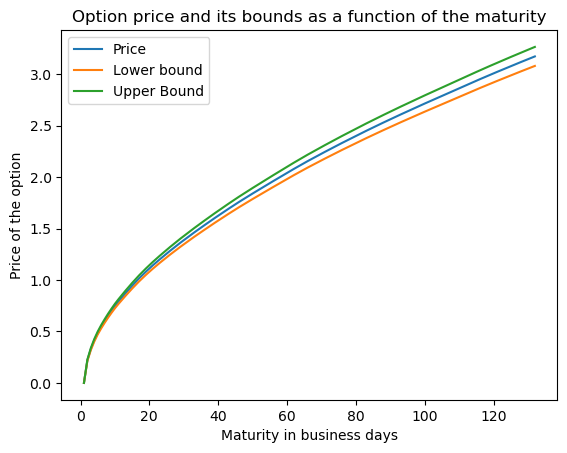

In [24]:
# Get the values
prices, confidence_interval = pricepermat(S)

# Plot
plt.plot(prices, label = 'Price')
plt.plot(confidence_interval, label = ['Lower bound', 'Upper Bound'])
plt.title('Option price and its bounds as a function of the maturity')
plt.xlabel('Maturity in business days')
plt.ylabel('Price of the option')
plt.legend()
plt.show()